In [1]:
import pandas as pd
import numpy as np
import scipy 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choices,sample

import os
import gc
import pickle

from tqdm import tqdm

plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

os.chdir("../../")
root_path = os.getcwd()

raw_file_path = os.path.join(root_path, "Bigcon2020_raw_file")
csv_file_path = os.path.join(root_path, "BigCon_2020/csv_files")
pickle_file_path = os.path.join(root_path, "BigCon_2020/pickle_files")
image_path = 'C:/Users/rears/OneDrive/바탕 화면/dacon_covid19/'

raw_file_folders = os.listdir(raw_file_path)

folder_path = os.path.join(raw_file_path, raw_file_folders[4])

c:\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
file_name=os.listdir(folder_path)[1]

In [3]:
file_path = os.path.join(folder_path, file_name)
cj_deliv = pd.read_excel(file_path)

In [4]:
from bs4 import BeautifulSoup
import requests

years = [2019,2020]
months  = ["01","02","03","04","05"]

holiday_list = []
for year in years:
    for month in tqdm(months):
        api_key = 'J5rBwA3iTfCmVk2bbIYJM7JalT9IhO%2FAYU0wz2xK3Je3NQRfcmf38Mj4hWl6j8KgR4C9IgOKo35cHkwLaw053A%3D%3D'
        url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getHoliDeInfo?solYear={}&solMonth={}&ServiceKey={}'.format(year,month,api_key)
        get_data = requests.get(url)
        soup = BeautifulSoup(get_data.content, 'html.parser')
        table = soup.find_all('locdate')
        holiday_list = holiday_list + [day.text for day in table]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:16<00:00, 15.39s/it]


In [5]:
holiday_list

[]

In [5]:
holiday = pd.to_datetime(['2020-04-15', '2020-04-30','2020-05-05'])

In [6]:
covid_df = pd.read_csv(os.path.join(csv_file_path,'covid19_일별확진자.csv'))
covid_df['날짜'] = pd.to_datetime(covid_df.날짜)

covid_df = covid_df.iloc[8:129]

In [7]:
cj_deliv['DL_YMD'] = pd.to_datetime(cj_deliv.DL_YMD.apply(lambda x : '20'+str(x)), format='%Y%m%d')

In [8]:
cj_deliv['year'] = cj_deliv.DL_YMD.dt.year.values
cj_deliv['month'] = cj_deliv.DL_YMD.dt.month.values
cj_deliv['weekofyear'] = cj_deliv.DL_YMD.dt.weekofyear.values
cj_deliv['dayofweek'] = cj_deliv.DL_YMD.dt.dayofweek.values

cj_deliv['weekday'] = np.where(cj_deliv.dayofweek < 5, '평일', '주말')

c:\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# 휴일의 경우 주말과 같이 처리
cj_deliv.loc[cj_deliv.DL_YMD.isin(holiday),'weekday'] = '주말'

In [17]:
cj_cat_unstack = cj_deliv.groupby(['DL_YMD','CTPV_NM','CTGG_NM','DL_GD_LCLS_NM'])['INVC_CONT'].sum().\
        reset_index().\
        pivot_table(values='INVC_CONT', index=['DL_YMD','CTPV_NM','CTGG_NM'], columns=['DL_GD_LCLS_NM'], aggfunc='sum').\
        reset_index().\
        sort_values(by=['CTPV_NM','CTGG_NM','DL_YMD']).\
        reset_index(drop=True).\
        fillna(0)

In [18]:
tmp_df = cj_deliv.groupby(['DL_YMD','CTPV_NM','CTGG_NM'])['INVC_CONT'].sum().reset_index()
# tmp_df = cj_deliv.groupby(['DL_YMD','CTPV_NM','CTGG_NM','DL_GD_LCLS_NM'])['INVC_CONT'].sum().reset_index()

대구광역시 수성구


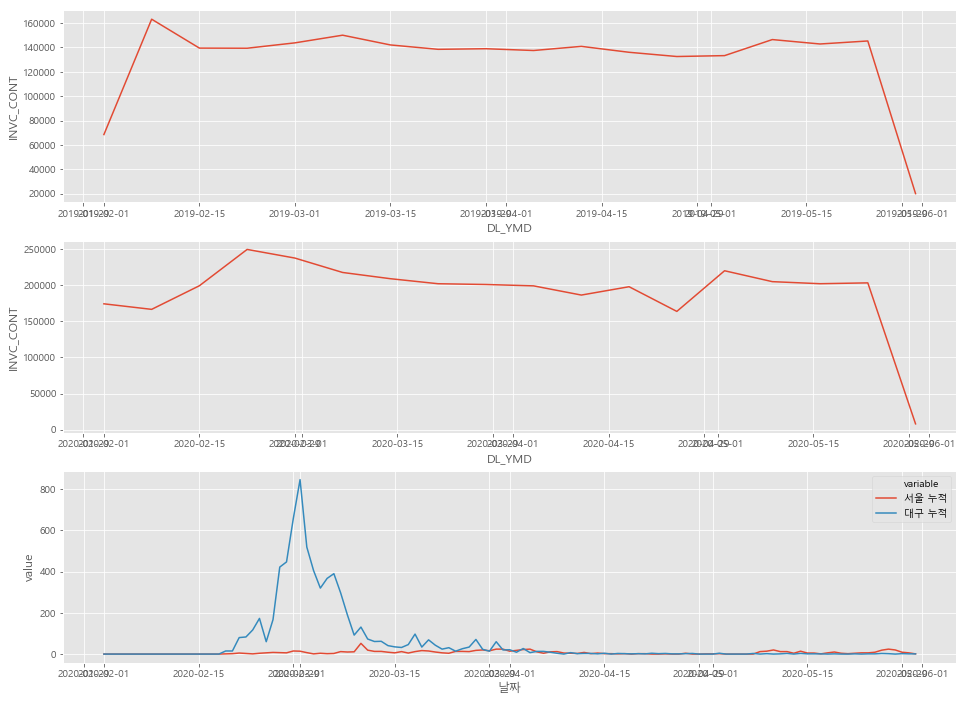

대구광역시 중구


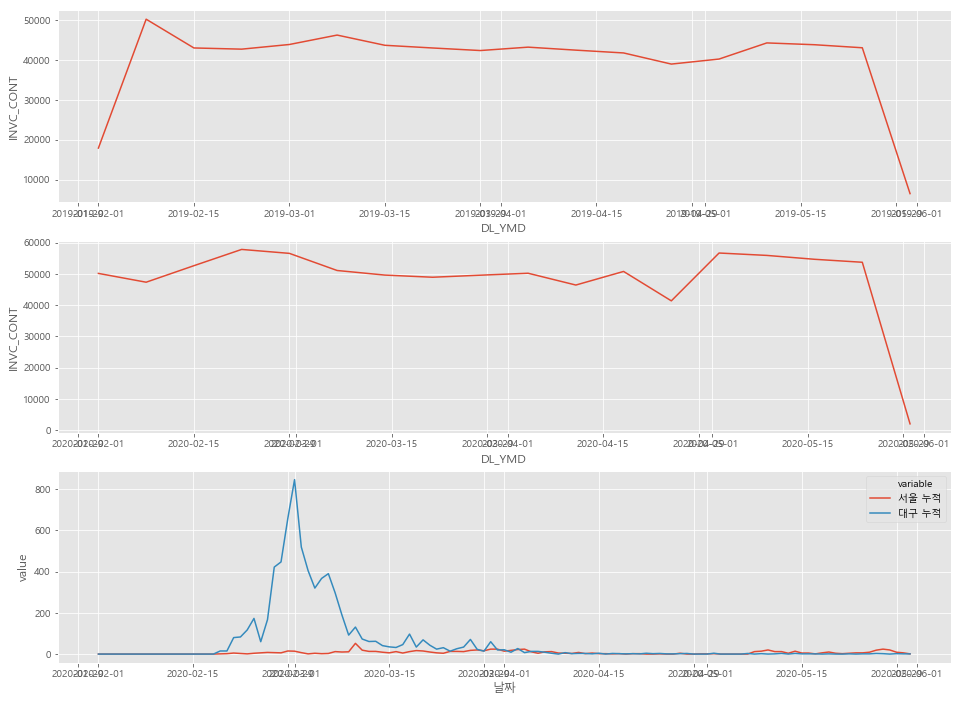

서울특별시 노원구


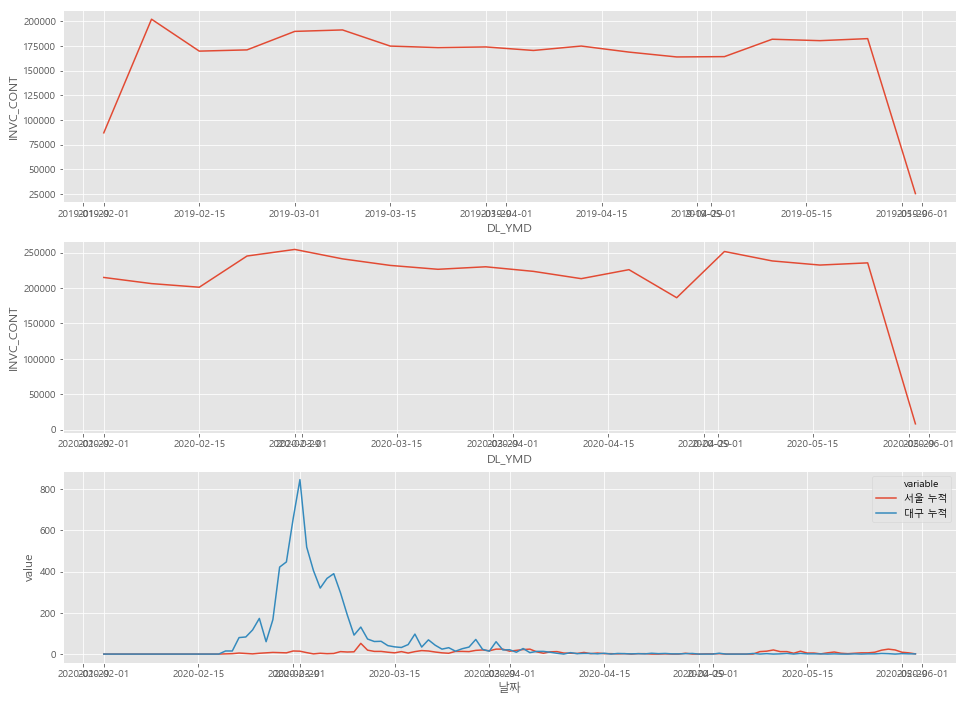

서울특별시 중구


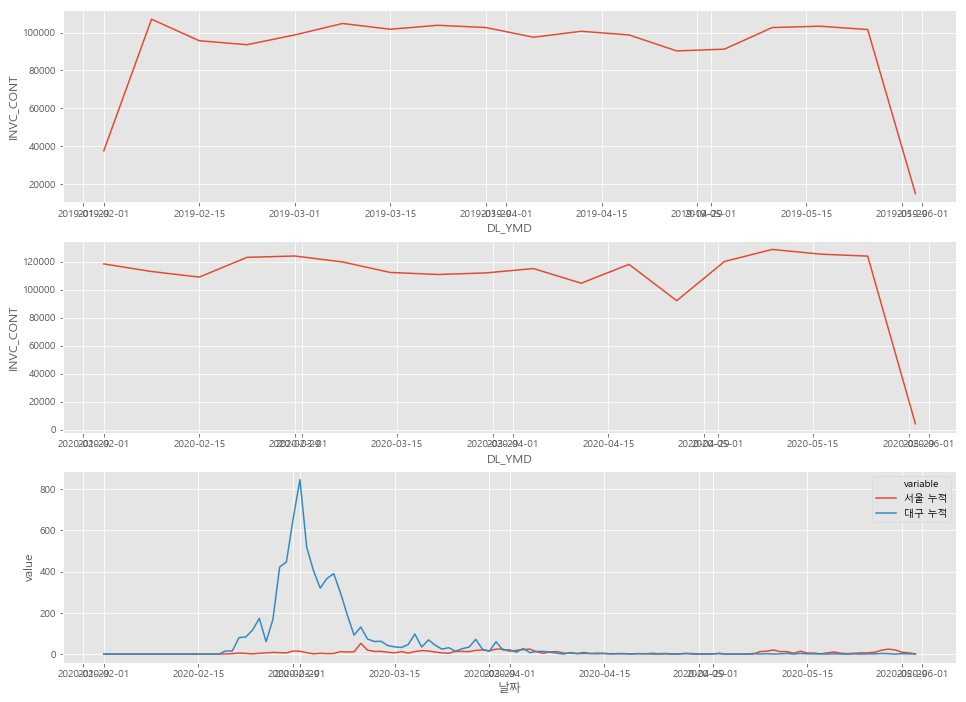

In [162]:
for si,gu in tmp_df.drop_duplicates(['CTPV_NM','CTGG_NM'])[['CTPV_NM','CTGG_NM']].values:
    print(f'{si} {gu}')
    tmp = tmp_df.loc[(tmp_df.CTPV_NM == si) & (tmp_df.CTGG_NM==gu) & (tmp_df.DL_YMD.dt.year==2020)]
    tmp1 = tmp_df.loc[(tmp_df.CTPV_NM == si) & (tmp_df.CTGG_NM==gu) & (tmp_df.DL_YMD.dt.year==2019)]
    
    plt.figure(figsize=(16,12))
    plt.subplot(311)
    sns.lineplot(
        data = tmp1.set_index('DL_YMD').resample('7D').sum().reset_index(),
        x = 'DL_YMD',
        y = 'INVC_CONT',
        #hue = 'DL_GD_LCLS_NM'
    )
    
    plt.subplot(312)
    sns.lineplot(
        data = tmp.set_index('DL_YMD').resample('7D').sum().reset_index(),
        x = 'DL_YMD',
        y = 'INVC_CONT',
        #hue = 'DL_GD_LCLS_NM'
    )
    
    plt.subplot(313)
    sns.lineplot(
        data = covid_df.iloc[:,[0,1,3]].melt(id_vars='날짜'),
        x = '날짜',
        y = 'value',
        hue = 'variable'
    )
    
    plt.show()

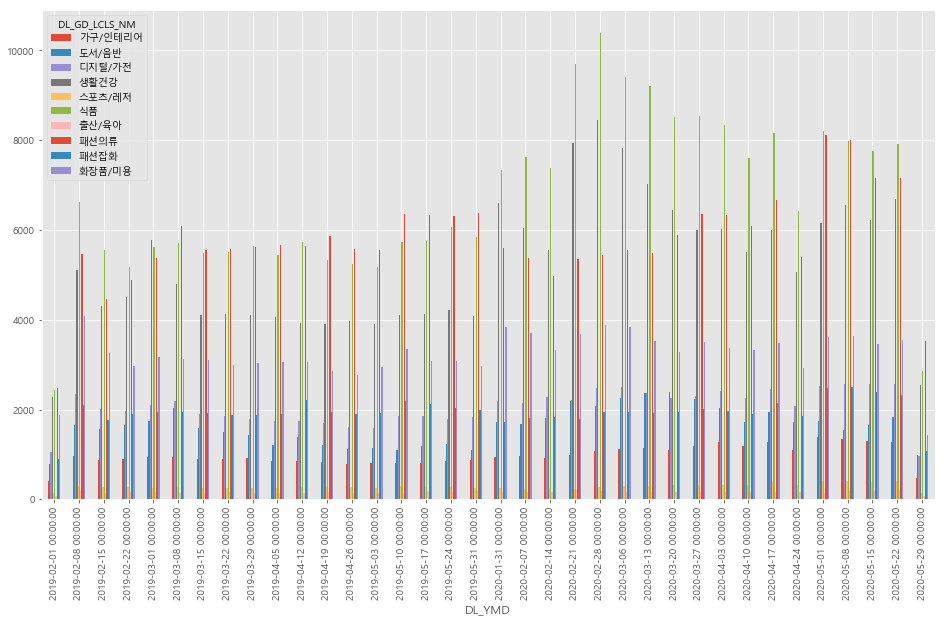

In [70]:
cj_cat_unstack.loc[cj_cat_unstack.CTGG_NM=='노원구'].set_index('DL_YMD').resample('7D').mean().dropna().plot(kind ='bar',figsize=(16,9))

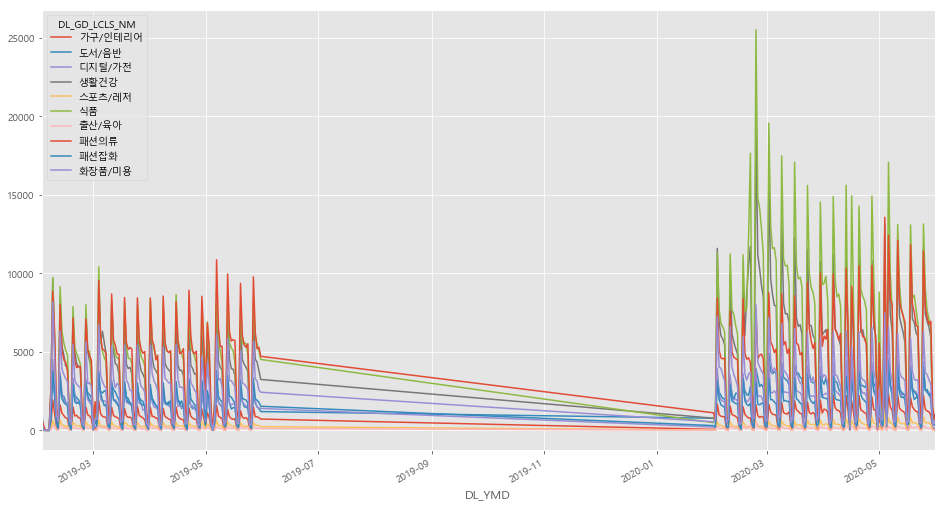

In [54]:
cj_cat_unstack.loc[cj_cat_unstack.CTGG_NM=='수성구'].set_index('DL_YMD').drop(['CTPV_NM','CTGG_NM'], axis=1).plot(figsize=(16,9))

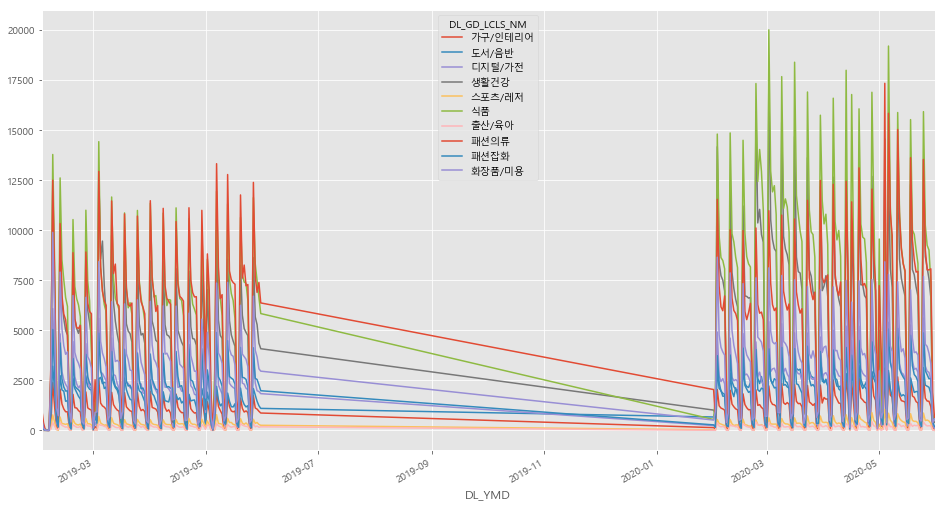

In [55]:
cj_cat_unstack.loc[cj_cat_unstack.CTGG_NM=='노원구'].set_index('DL_YMD').drop(['CTPV_NM','CTGG_NM'], axis=1).plot(figsize=(16,9))

In [32]:
cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM=='식품')].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna()

DL_YMD
2019-02-07     8025.6
2019-02-08    11795.6
2019-02-11    17905.8
2019-02-12    22194.6
2019-02-13    24714.8
               ...   
2020-05-25    27680.8
2020-05-26    27815.8
2020-05-27    27178.0
2020-05-28    26894.2
2020-05-29    26446.0
Name: INVC_CONT, Length: 167, dtype: float64

In [36]:
cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM==cat)].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna().index

DatetimeIndex(['2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21',
               ...
               '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21',
               '2020-05-22', '2020-05-25', '2020-05-26', '2020-05-27',
               '2020-05-28', '2020-05-29'],
              dtype='datetime64[ns]', name='DL_YMD', length=166, freq=None)

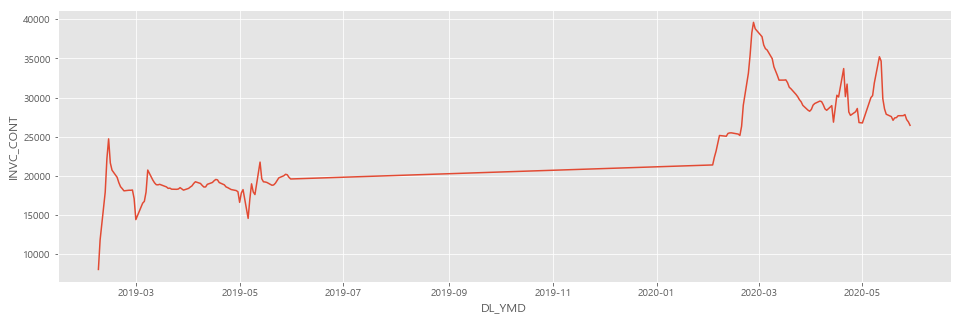

In [10]:
plt.figure(figsize=(16,5))
sns.lineplot(
    x=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM=='식품')].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna().index,
    y=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM=='식품')].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna()
)

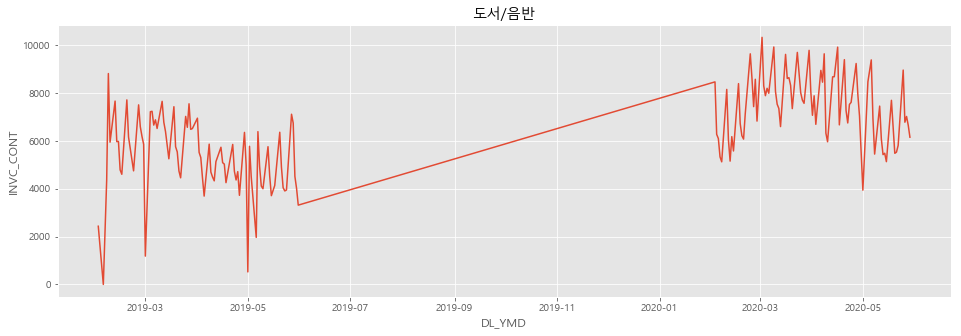

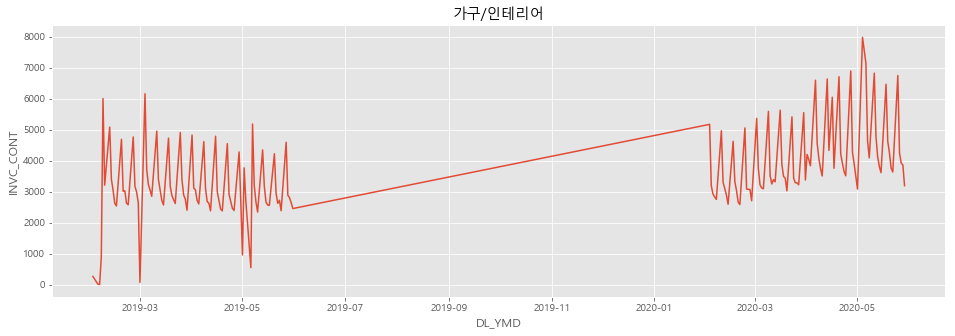

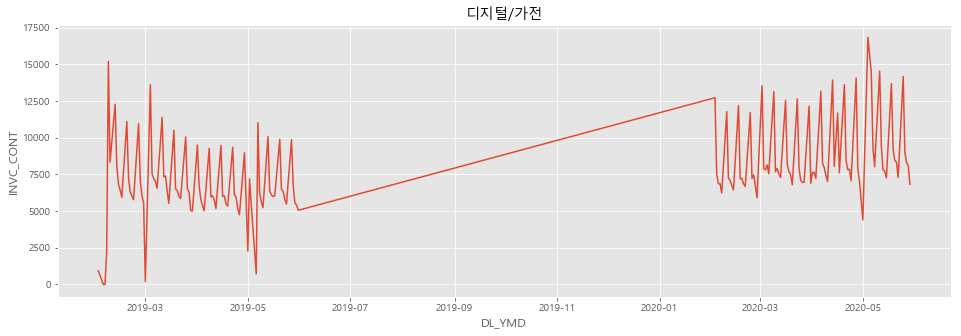

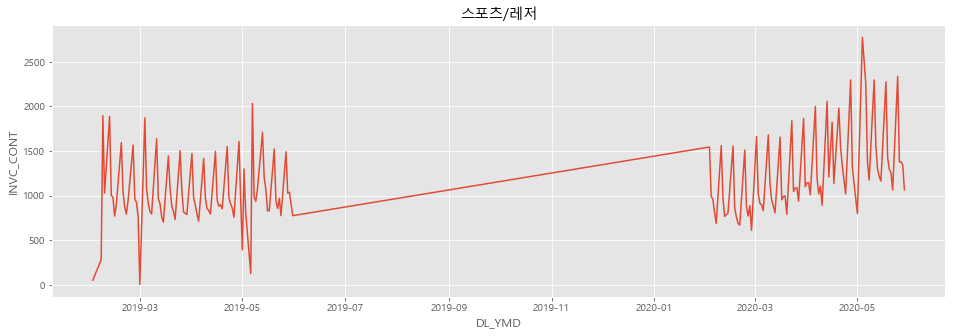

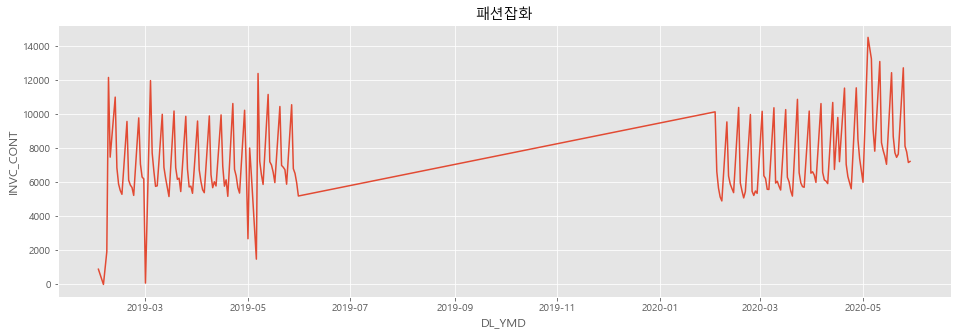

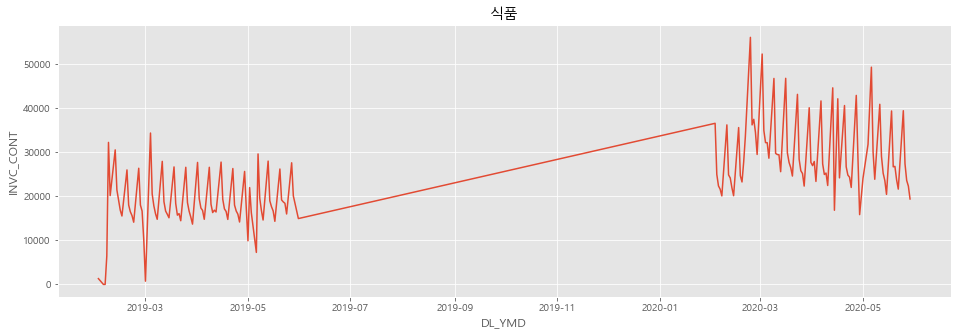

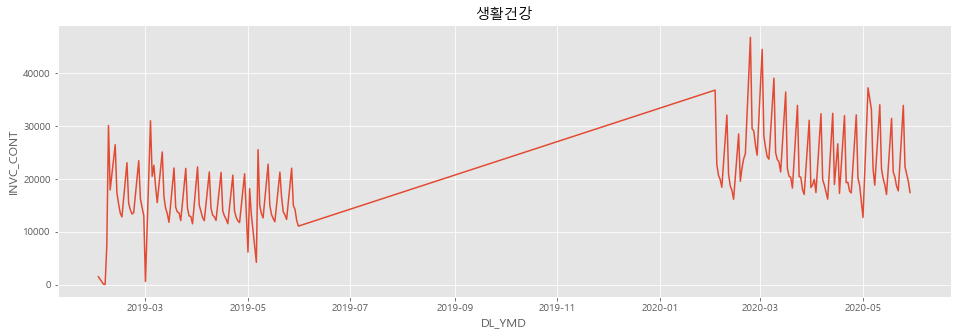

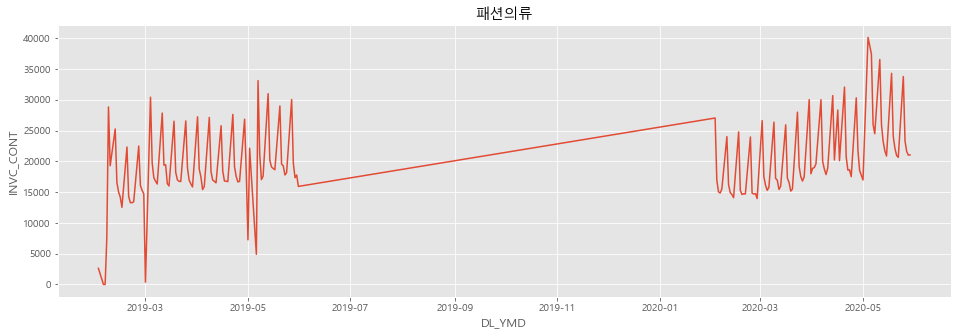

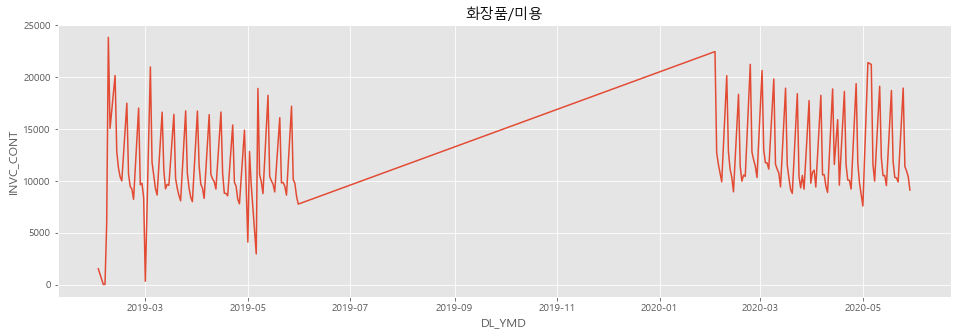

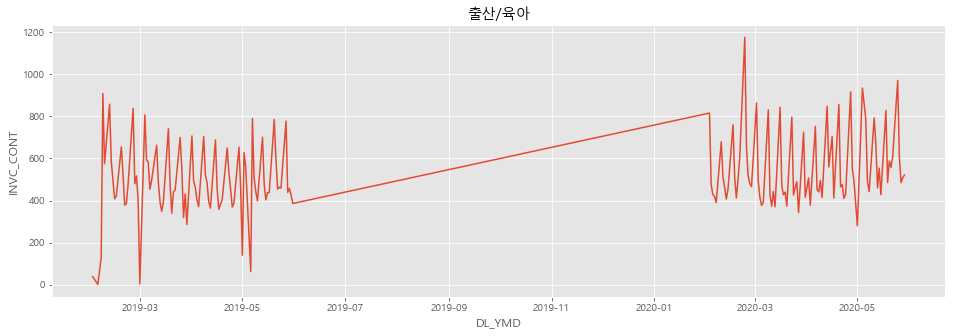

In [11]:
for cat in cj_deliv.DL_GD_LCLS_NM.unique():
    
    plt.figure(figsize=(16,5))
    sns.lineplot(
        x=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM==cat)].groupby('DL_YMD')['INVC_CONT'].sum().index,
        y=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM==cat)].groupby('DL_YMD')['INVC_CONT'].sum()
    )
    plt.title(cat)
    plt.show()

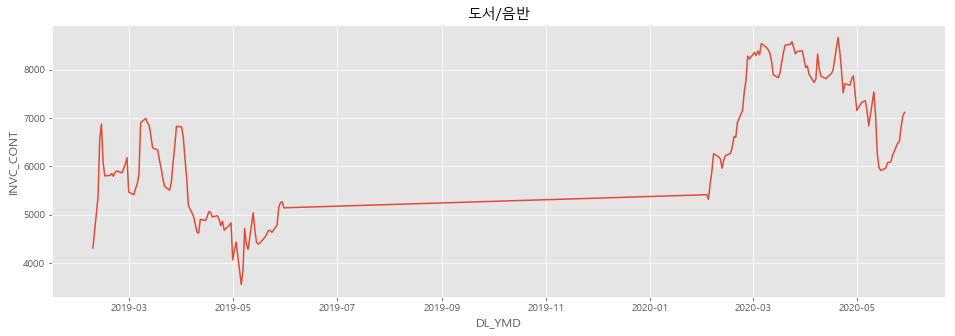

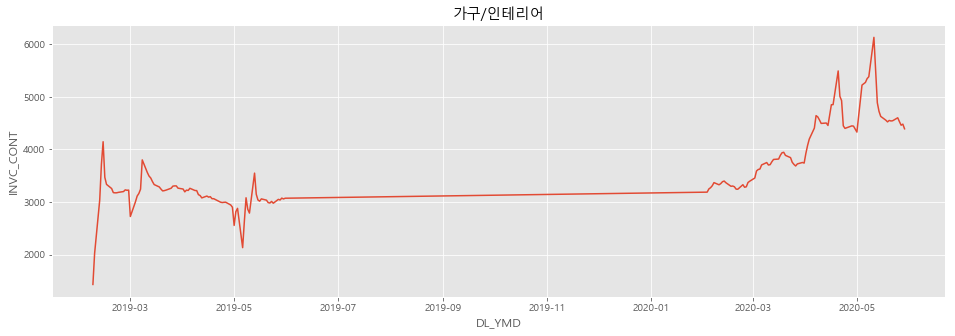

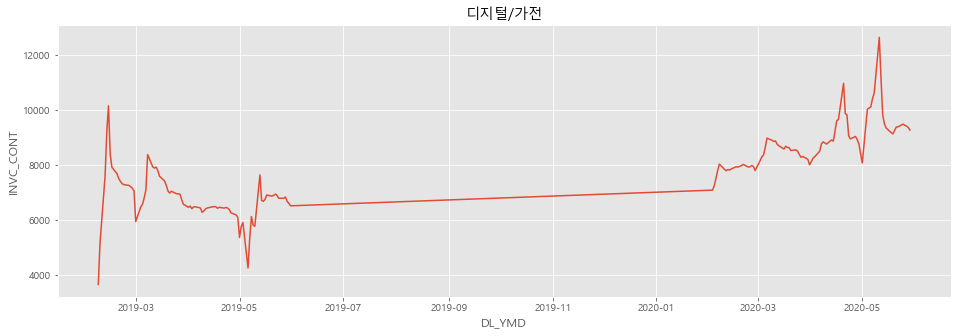

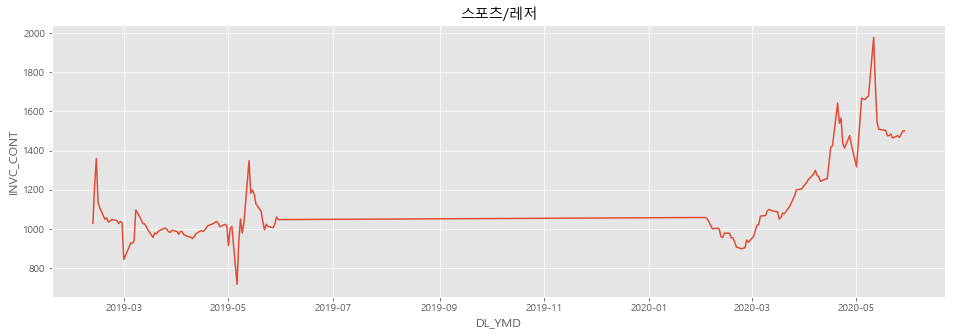

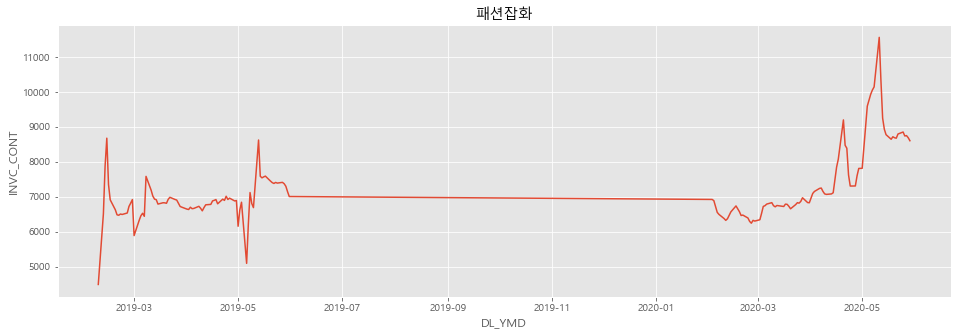

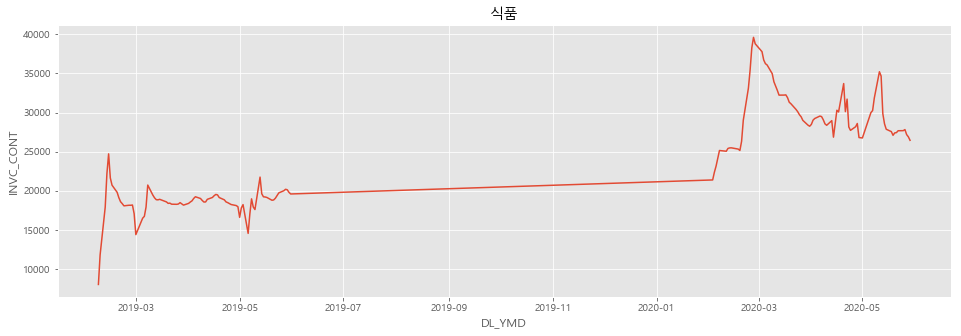

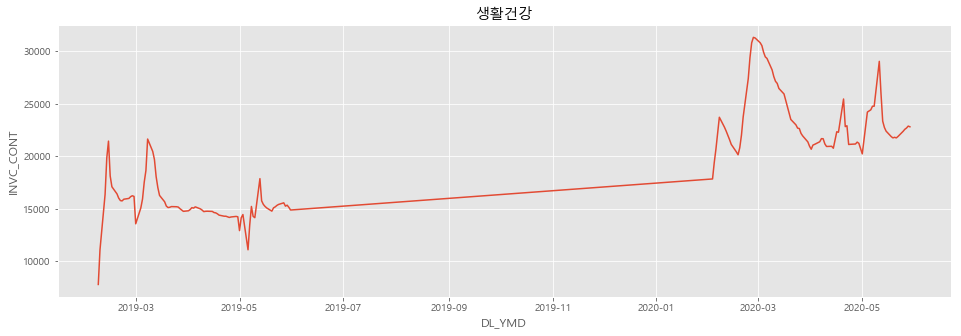

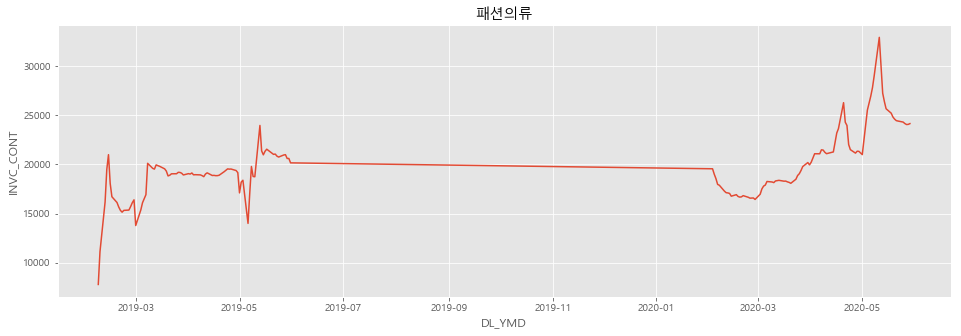

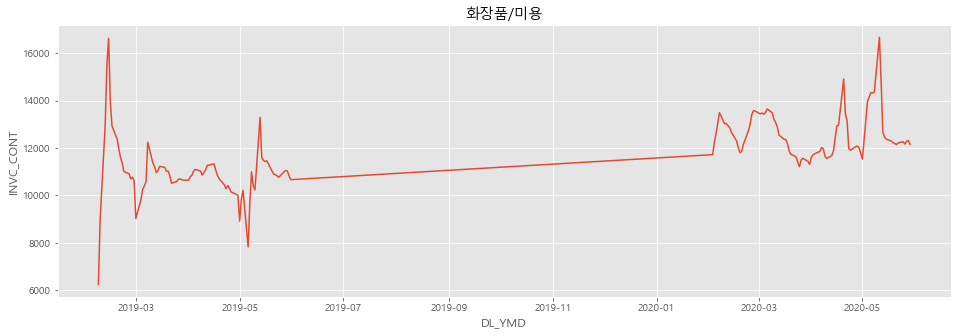

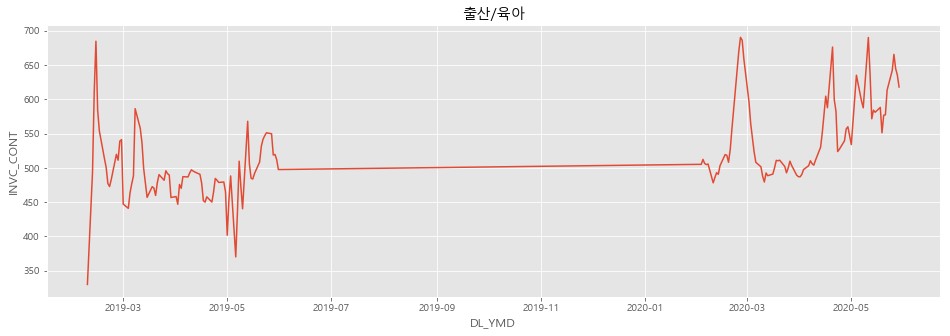

In [23]:
for cat in cj_deliv.DL_GD_LCLS_NM.unique():
    
    plt.figure(figsize=(16,5))
    sns.lineplot(
        x=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM==cat)].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna().index,
        y=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM==cat)].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna()
    )
    plt.title(cat)
    plt.show()

In [45]:
cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.year==2020) & (cj_deliv.month < 5)].groupby(['DL_YMD','DL_GD_LCLS_NM'])['INVC_CONT'].sum().reset_index()

,DL_YMD,DL_GD_LCLS_NM,INVC_CONT
0,2020-02-03,가구/인테리어,5168
1,2020-02-03,도서/음반,8468
2,2020-02-03,디지털/가전,12720
3,2020-02-03,생활건강,36825
4,2020-02-03,스포츠/레저,1545
...,...,...,...
635,2020-04-30,식품,648
636,2020-04-30,출산/육아,8
637,2020-04-30,패션의류,218
638,2020-04-30,패션잡화,525


In [11]:
cj_deliv.loc[cj_deliv.DL_YMD=='2020-04-30']

,DL_YMD,DL_GD_LCLS_NM,DL_GD_LCLS_CD,CTPV_NM,CTPV_CD,CTGG_NM,CTGG_CD,HDNG_NM,HDNG_CD,INVC_CONT,year,month,weekofyear,dayofweek,weekday
135623,2020-04-30,생활건강,15,서울특별시,11,중구,14,장충동,580,2,2020,4,18,3,평일
135624,2020-04-30,가구/인테리어,10,대구광역시,27,수성구,26,고산2동,680,2,2020,4,18,3,평일
135625,2020-04-30,가구/인테리어,10,대구광역시,27,수성구,26,범물2동,662,2,2020,4,18,3,평일
135626,2020-04-30,가구/인테리어,10,서울특별시,11,중구,14,동화동,665,1,2020,4,18,3,평일
135627,2020-04-30,스포츠/레저,16,서울특별시,11,노원구,35,월계3동,580,1,2020,4,18,3,평일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136090,2020-04-30,화장품/미용,21,대구광역시,27,중구,11,동인동,517,2,2020,4,18,3,평일
136091,2020-04-30,화장품/미용,21,대구광역시,27,중구,11,성내1동,565,2,2020,4,18,3,평일
136092,2020-04-30,식품,17,대구광역시,27,중구,11,성내3동,585,2,2020,4,18,3,평일
136093,2020-04-30,패션잡화,20,서울특별시,11,노원구,35,중계1동,621,12,2020,4,18,3,평일
